In [1]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data, exposure_combined_exponential
from utilities.plotting import plot_exposure_contour

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

if not os.path.exists('Figures/exposure_function') :
    os.makedirs('Figures/exposure_function')

In [3]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')
ac_data = ac_data.dropna()

print(ac_data)

# Save the data to a csv file
ac_data.to_csv("air_conditioning_data.csv")


          country    AC  Year ISO3       Country         CDD           GDP
0       Australia  0.75  2011  AUS     Australia   623.88516  45405.365365
1          Canada  0.48  2011  CAN        Canada   192.54118  45823.164240
3     Netherlands  0.11  2011  NLD   Netherlands    42.97206  52594.229006
4           Spain  0.54  2011  ESP         Spain   645.73456  36883.322978
5          Sweden  0.20  2011  SWE        Sweden    33.84952  48947.439311
..            ...   ...   ...  ...           ...         ...           ...
120        Mexico  0.16  2018  MEX        Mexico  1143.25515  20278.216307
121        Brazil  0.16  2018  BRA        Brazil  2050.51273  14619.591130
122     Indonesia  0.09  2018  IDN     Indonesia  2859.99639  11397.431401
123  South Africa  0.06  2018  ZAF  South Africa   761.20591  13990.314893
124         India  0.05  2018  IND         India  2982.11497   6436.153402

[76 rows x 7 columns]


In [4]:
def sat(cdd, a):
    return 1. - np.exp(-a * cdd)

# Corrected avail function
def avail(gdp, b, c):
    return 1 / (1 + np.exp(b) * np.exp(-c * gdp))

# Adjusted exposure function to fit the curve_fit requirements
def ac_access(xdata, a, b, c):
    cdd, gdp = xdata
    return (sat(cdd, a) * avail(gdp, b, c))

def avail_alt(gdp, b, c):
    return (gdp**b / (gdp**b + c**b))

def ac_access_alt(xdata, a, b, c):
    cdd, gdp = xdata
    return (sat(cdd, a) * avail_alt(gdp, b, c))


# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1000., ac_data["GDP"]/100000.)
ydata = ac_data["AC"]

# Fit the exposure function
popt, pcov = curve_fit(ac_access, xdata, ydata)

print(popt)

[4.36775517 2.57860164 8.21963774]


In [5]:
popt[0] /= 1000
popt[2] /= 100000
with open('exposure_function_params_exponential.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt[0], 'alpha': popt[1], 'k': popt[2]}, f)
print(popt)

[4.36775517e-03 2.57860164e+00 8.21963774e-05]


In [6]:
# Add column to ac_data with the fitted exposure function
ac_data["AC calculated"] = sat(ac_data["CDD"], popt[0]) * avail(ac_data["GDP"], popt[1], popt[2])
print(ac_data)

          country    AC  Year ISO3       Country         CDD           GDP  \
0       Australia  0.75  2011  AUS     Australia   623.88516  45405.365365   
1          Canada  0.48  2011  CAN        Canada   192.54118  45823.164240   
3     Netherlands  0.11  2011  NLD   Netherlands    42.97206  52594.229006   
4           Spain  0.54  2011  ESP         Spain   645.73456  36883.322978   
5          Sweden  0.20  2011  SWE        Sweden    33.84952  48947.439311   
..            ...   ...   ...  ...           ...         ...           ...   
120        Mexico  0.16  2018  MEX        Mexico  1143.25515  20278.216307   
121        Brazil  0.16  2018  BRA        Brazil  2050.51273  14619.591130   
122     Indonesia  0.09  2018  IDN     Indonesia  2859.99639  11397.431401   
123  South Africa  0.06  2018  ZAF  South Africa   761.20591  13990.314893   
124         India  0.05  2018  IND         India  2982.11497   6436.153402   

     AC calculated  
0         0.710333  
1         0.435839  


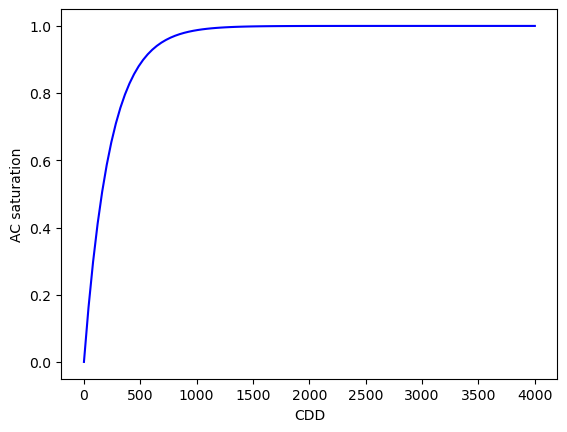

In [7]:
# Plot saturation function
cdd = np.linspace(0, 4000, 100)
plt.plot(cdd, sat(cdd, popt[0]), color='blue')
plt.xlabel("CDD")
plt.ylabel("AC saturation")
plt.savefig("Figures/exposure_function/saturation_exponential_fit.png")

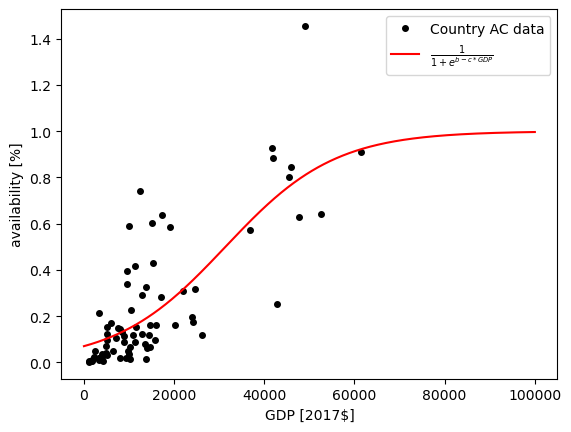

In [8]:
# Plot the availability function
fig, ax = plt.subplots()
ax.plot(ac_data["GDP"], ac_data["AC"]/sat(ac_data["CDD"], popt[0]), 'o', label="Country AC data", markersize=4, color='black')
x = np.linspace(0, 100000, 1000)
y = avail(x, popt[1], popt[2])
ax.plot(x, y, color='red', label=r'$\frac{1}{1+e^{b - c*GDP}}$')
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("availability [%]")
ax.legend()
plt.savefig("Figures/exposure_function/availability_exponential_fit.png")

In [9]:
# Alternative fit function

popt_gdp, pcov_gdp = curve_fit(ac_access_alt, xdata, ydata)

popt_gdp[0] /= 1000
popt_gdp[2] *= 100000

with open('exposure_function_params_power_law.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt_gdp[0], 'alpha': popt_gdp[1], 'k': popt_gdp[2]}, f)

print(popt_gdp)

[4.95607102e-03 1.58506563e+00 2.99247517e+04]


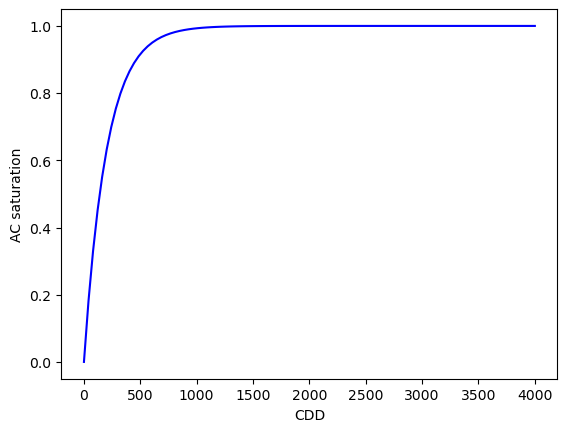

In [10]:
# Plot saturation function
cdd = np.linspace(0, 4000, 100)
plt.plot(cdd, sat(cdd, popt_gdp[0]), color='blue')
plt.xlabel("CDD")
plt.ylabel("AC saturation")
plt.savefig("Figures/exposure_function/saturation_power_fit.png")

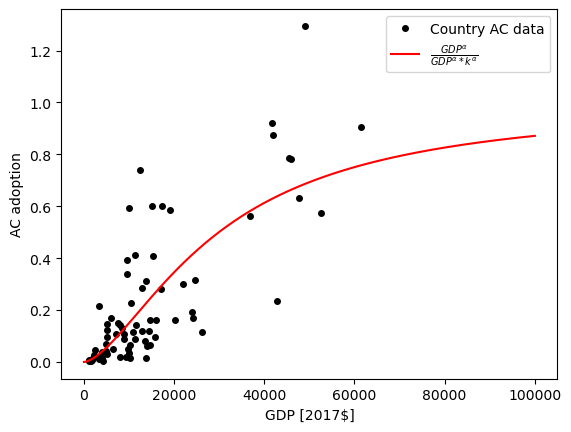

In [11]:
# Plot the fit
fig, ax = plt.subplots()
gdp_range = np.linspace(0, 100000., 1000)
ax.plot(ac_data["GDP"], ac_data["AC"]/sat(ac_data["CDD"], popt_gdp[0]), 'o', markersize=4, color="black", label="Country AC data")
ax.plot(gdp_range, avail_alt(gdp_range, popt_gdp[1], popt_gdp[2]), color="red", label=r"$\frac{GDP^{\alpha}}{GDP^{\alpha} * k^{\alpha}}$")
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("AC adoption")
ax.legend()
# Save the plot
plt.savefig("Figures/exposure_function/availability_power_fit.png")

In [12]:
# Alternative fit function
xdata = (ac_data["CDD"], ac_data["GDP"])
ydata = (1. - ac_data["AC"])
popt_comb, pcov_comb = curve_fit(exposure_combined_exponential, xdata, ydata)

with open('exposure_function_params_combined_exponential.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt_comb[0], 'alpha': popt_comb[1], 'k': popt_comb[2]}, f)

print(popt_comb)

[2.68787538 0.29301718 1.29450614]


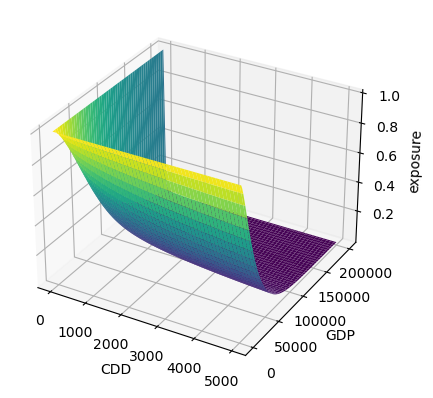

In [13]:
# Plot the fit in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cdd = np.linspace(0, 5000, 100)
gdp = np.linspace(0, 200000, 100)
cdd, gdp = np.meshgrid(cdd, gdp)
ac = exposure_combined_exponential((cdd, gdp), *popt_comb)
ax.plot_surface(cdd, gdp, ac, cmap='viridis')
ax.set_xlabel("CDD")
ax.set_ylabel("GDP")
ax.set_zlabel("exposure")
plt.savefig("Figures/exposure_function/combined_exponential_fit.png")

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1419: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1421: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:830: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:831: FutureWarning: Calling float on a single element Series

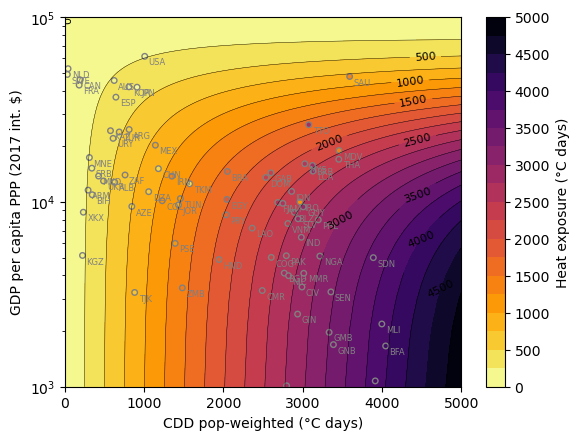

In [14]:
def exposure_f(cdd, gdp):
    return exposure_combined_exponential((cdd, gdp), *popt_comb)

plot_exposure_contour(config, exposure_f, ac_data, 
                    x_y_ranges=[[config['plotting']['cdd_min'], config['plotting']['cdd_max'], 100],
                                    [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]], 
                    name_tag='exposure_contour_control', control=True)

Text(0, 0.5, 'exposure GDP component')

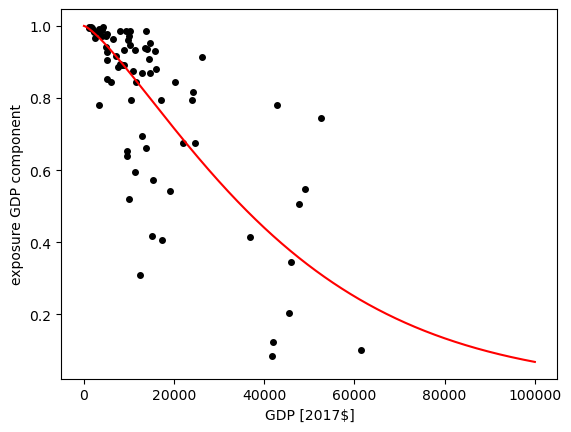

In [15]:
# Plot the fit in 2D
fig, ax = plt.subplots()
ac_data_points = (1. - ac_data['AC']) ** (1./((ac_data['CDD']/1000.)**popt_comb[1]))
ax.plot(ac_data['GDP'], ac_data_points, 'o', markersize=4, color="black", label="Country AC data")
gdp_range = np.linspace(0, 100000, 1000)
ax.plot(gdp_range, np.exp(-popt_comb[0] * (gdp_range/100000.)**popt_comb[2]), color="red", label=r"$\exp(-\alpha * GDP^k)$")
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("exposure GDP component")